# Simultaneous Imitation

## Abstract
This paper is about eye-dynamics for an imitation task.


## Imitation Task
This is the video, subjects saw the video and imitated movements **simultaneously**.
<iframe width="560" height="315" src="https://www.youtube.com/embed/2hhV0Ev2PDQ"></iframe>


## Subject heatmap and Grand Average

We calculate the grand average data heatmap for fixation, data ranges are [0, 48] and [0, 30] for 
(x, y) respectively so we need to filter data as the next scatter plot shows.

Cartesian data is saved in this way because these ranges are needed to compute angular degrees for smooth
pursuit, saccades and fixations.


97.96991508986682% of data inside this range


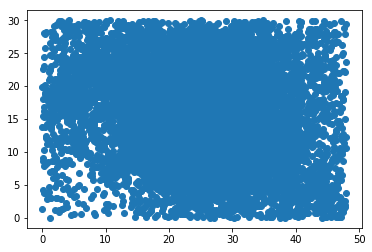

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./source_data/data.csv')

x0 = data['x_start']  # index = 2
y0 = data['y_start']  # index = 3

mask = [(x > 0) and (x < 48) and (y > 0) and (y < 30) for x, y in zip(x0, y0)]
print("{}% of data inside this range".format(100*sum(mask)/len(mask)))
plt.scatter(x0[mask], y0[mask])
plt.show()


## Creating a trial-only mask and modify x-y coordinates
From all data points we need to use only those points inside useful trial intervals so we need to mask them, we also
modify x-y coords that were normalized by 48, 30. Finally, we save this trial id mask in a modified
data file.


In [4]:
import pandas as pd
import numpy as np


# resize x-y
data = pd.read_csv('./source_data/data.csv')
data['x_start'] = data['x_start']*1920/48
data['x_end'] = data['x_end']*1920/48
data['y_start'] = data['y_start']*1080/30
data['y_end'] = data['y_end']*1080/30
t0 = data['time_start'].as_matrix()
subject = data['subject'].as_matrix() - 1  # subject1 is 0 in python

trial_data = pd.read_excel('./source_data/Frames.xlsx')
ids = trial_data['id'].as_matrix()

# mark trials 1 to 5 with that number, passive observation as 0, -1 everything else
# take out the invalid subjects, marked with 0 as id
mask = [i for i in range(len(ids)) if ids[i] > 0]

# transform frame tags to time, videos were at 30fps
intervals = [(trial_data['passivei'].as_matrix()[mask]/30, trial_data['passivef'].as_matrix()[mask]/30), 
             (trial_data['t1i'].as_matrix()[mask]/30, trial_data['t1f'].as_matrix()[mask]/30), 
             (trial_data['t2i'].as_matrix()[mask]/30, trial_data['t2f'].as_matrix()[mask]/30), 
             (trial_data['t3i'].as_matrix()[mask]/30, trial_data['t3f'].as_matrix()[mask]/30), 
             (trial_data['t4i'].as_matrix()[mask]/30, trial_data['t4f'].as_matrix()[mask]/30), 
             (trial_data['t5i'].as_matrix()[mask]/30, trial_data['t5f'].as_matrix()[mask]/30)]

trial_id = np.zeros(t0.shape) - 1
for data_index in range(len(trial_id)):
    for tuple_index in range(len(intervals)):
        interval_low = intervals[tuple_index][0]
        interval_high = intervals[tuple_index][1]
        low = interval_low[subject[data_index]]
        high = interval_high[subject[data_index]]
        
        if low < t0[data_index] < high:
            trial_id[data_index] = tuple_index
            
# add this mask to data csv
data['trial_id'] = trial_id

# calculate percentage of data outside of a trial
ratio = np.sum(trial_id == -1) / len(trial_id) 
print("{}% of Data outside of trials".format(ratio*100))

# make a modified file
data.to_csv('./source_data/data_modified.csv')


/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/harrisonford/PycharmProjects/accelerometer-data/venv/li

74.20369811646049% of Data outside of trials


Taking this in mind we resize data to real monitor setting, rewrite modified data 
and create the heatmap:


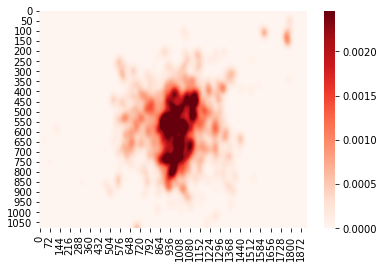

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2


# we create an aux function to create a mask of values inside event list and trial list
# event ids: 1,2,3 = sacc, fix, sp
# trial ids: [1, ... ,5]
def create_mask(loaded_data, event_list, trial_list):
    _mask = [(x > 0) and (x < 1920) and (y > 0) and (y < 1080) and (my_event in event_list) and (my_trial in trial_list)
            for x, y, my_event, my_trial 
            in zip(loaded_data['x_start'], loaded_data['y_start'], loaded_data['type'], loaded_data['trial_id'])]
    return _mask


# import data
data = pd.read_csv('./source_data/data_modified.csv')
duration = data['duration']

# make the mask, modify these values to select data to plot
mask = create_mask(data, [2], [1, 2, 3, 4, 5])

# translate to a heatmap
heatmap = np.zeros((1080, 1920))
for x, y, t, valid in zip(data['x_start'], data['y_start'], duration, mask):
    if valid:
        heatmap[int(y), int(x)] = t

# gaussian filter heatmap
blurred_heatmap = cv2.GaussianBlur(heatmap, (0, 0), 20)

sb.heatmap(blurred_heatmap, cmap='Reds', robust=True)
plt.show()


## Fixation/Saccade/SmoothPursuit Characterization Overview

We calculate mean fixation duration and number as grand-average.


Grand average fix 0.35375081353631066
Grand average sacc 0.05851383952482124
Grand average smooth 0.9650315557224927


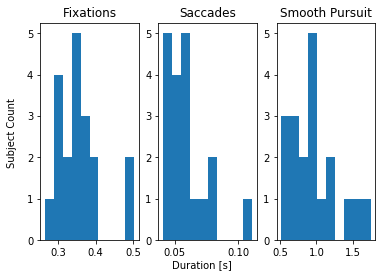

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# create a function that averages duration per subject
def group_average_duration(dataframe, event_id):
    times = dataframe['duration']
    subject_mask = dataframe['subject']
    type_mask = dataframe['type'] 
    trial_mask = dataframe['trial_id']
    n_subjects = subject_mask.max()
    mean_data = np.empty(n_subjects)
    
    for n in range(n_subjects):
        subject_data = [time for index, time in enumerate(times) 
                        if subject_mask[index] == n+1 and type_mask[index] == event_id and trial_mask[index] >= 0]
        mean_data[n] = np.nanmean(subject_data)  # change to use np.nanmean() for duration or len() for quantity
    return mean_data


# import data
data = pd.read_csv('./source_data/data_modified.csv')

# average events
data_type = dict(sacc=1, fix=2, smp=3)  # smp = smooth pursuit
sacc_duration = group_average_duration(data, data_type['sacc'])
fix_duration = group_average_duration(data, data_type['fix'])
smp_duration = group_average_duration(data, data_type['smp'])


print("Grand average fix {}".format(np.nanmean(fix_duration)))
print("Grand average sacc {}".format(np.nanmean(sacc_duration)))
print("Grand average smooth {}".format(np.nanmean(smp_duration)))

# plot average duration for subjects histogram
fig, axes = plt.subplots(1, 3)
axes[0].hist(fix_duration)
axes[0].set_title("Fixations")
axes[1].hist(sacc_duration)
axes[1].set_title("Saccades")
axes[2].hist(smp_duration)
axes[2].set_title("Smooth Pursuit")

# Set common labels
fig.text(0.5, 0.04, 'Duration [s]', ha='center', va='center')
fig.text(0.06, 0.5, 'Subject Count', ha='center', va='center', rotation='vertical')

plt.savefig("average_durations.png", dpi=1000)
plt.show()

## Calculate Fix-Sacc-SmoothP per Trial


/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


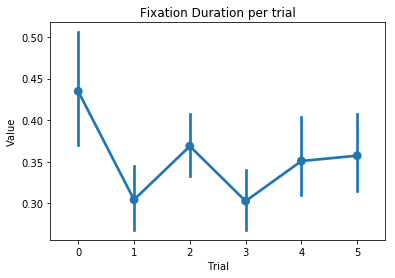

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     3.971
Date:                Sun, 18 Aug 2019   Prob (F-statistic):            0.00240
Time:                        19:44:38   Log-Likelihood:                 96.662
No. Observations:                 114   AIC:                            -181.3
Df Residuals:                     108   BIC:                            -164.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4347      0.024     17.797      0.000       0.386       0.483
C(Trial)[T.1]    -0.1304      0.035     -3.775      0.000      -0.199      -0.062
C(Trial)[T.2]    -0.0659      0.035     -1.909      0.059      -0.134       0.003
C(Trial)[T.3]    -0.1320      0.035     -3.821      0.000      -0.200      -0.064
C(Trial)[T.4]    -0.0838      0.035     -2.426      0.017      -0.152      -0.015
C(Trial)[T.5]    -0.0774      0.035     -2.241      0.027      -0.146      -0.009
==============================================================================
Omnibus:                       22.274   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.922
Skew:                           0.982   Prob(JB):                     1.93e-07
Kurtosis:                       4.629   Cond. No.                         6.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
# import statsmodels.api as sm
from statsmodels.formula.api import ols


# change here to chose data to plot
type_dict = dict(Saccade=1, Fixation=2, Smooth_Pursuit=3)
chosen_type = 'Fixation'
data_value = 'Duration'

# import data
data = pd.read_csv('./source_data/data_modified.csv')
data_type = data['type']
trial_id = data['trial_id']
duration = data['duration']
subject_id = data['subject']
data_list = []  # save subject, trial, duration or quantity
for trial in range(6):
    for subject in range(20):
        sub_times = [a_time for a_time, sub, tag, t_id in zip(duration, subject_id, data_type, trial_id)
                 if sub == subject and tag == type_dict[chosen_type] and t_id == trial]
        if data_value == 'Quantity':
            data_list.append([subject, trial, len(sub_times)])
        else:
            data_list.append([subject,trial, np.nanmean(sub_times)])

# summarize into a dataframe
grand_averages = pd.DataFrame(data_list, columns=["Subject", "Trial", "Value"])
point_plot = sns.pointplot(
    x="Trial", y="Value", data = grand_averages).set_title("{} {} per trial".format(chosen_type, data_value))
fig = point_plot.get_figure()
fig.savefig("{}_{}_trials.png".format(chosen_type, data_value), dpi=1000)
plt.show()

# apply ANOVA for significance
anova = ols('Value ~ C(Trial)', data=grand_averages).fit()
anova.summary()
# aov_table = sm.stats.anova_lm(anova, typ=2)
# aov_table


## Add Region of Interest (ROI)
We add ROI tag in data modified using tracking in source data. First, we add three columns
to the file fpr which ROI is moving at any given moment on the screen 
(screen_ROI_id and x-y values), then, we'll add which ROI the subject is looking into
(looked_ROI_id and x-y values).

In [4]:
import numpy as np
import os
import pandas as pd


# import data and tracking annotations
data = pd.read_csv('./source_data/data_modified.csv')
tracking_path = './source_data/tracking/'
file_list = os.listdir(tracking_path)
tracking_container = [pd.read_csv(tracking_path + a_file, delimiter='\t') for 
                      a_file in file_list]
# for each data x-y point we need TTL + time = real time and check 
# best distance to a ROI
# load TTL data
trial_data = pd.read_excel('./source_data/Frames.xlsx')
TTL = trial_data['TTL'].as_matrix()
valid_ids = trial_data['id']
# pick TTL only to those counted as valid subjects (id > 0)
TTL = [a_ttl for a_ttl, valid in zip(TTL, valid_ids) if valid > 0]
screen_ROI_ids = []
looked_ROI_ids = []
looked_ROI_distances = []
for t, x, y, subject, trial_id in zip(data['time_start'], data['x_start'], data['y_start'], 
                                   data['subject'], data['trial_id']):
    my_TTL = TTL[subject - 1]  # subject starts at 1 but index at 0
    # check for this data point the nearest ROI
    ROI_id = -1
    ROI_distance = -1
    if trial_id < 0:  # value not inside trial we just append -1 as it's non-valid
        screen_ROI_ids.append(ROI_id)
        looked_ROI_ids.append(ROI_id)
        looked_ROI_distances.append(ROI_distance)
        continue
    # for a valid trial we need the starting time to check the relative time to the video
    # this gives the correct excel column
    frame_vector = trial_data.as_matrix(columns=[trial_data.columns[3 + 2*trial_id]])
    frame_vector = [a_frame_value[0] for a_frame_value, valid in zip(frame_vector, valid_ids)
                    if valid > 0]  # this takes invalid subjects out
    # with starting frame use time instead (video at 30 fps)
    video_start_time = frame_vector[subject - 1]/30
    current_time = t - video_start_time
    
    for ROI_index, a_ROI in enumerate(tracking_container):
        # check nearest roi and moving roi
        roi_times = a_ROI['t']
        match_threshold = 0.033  # this time dif means we're on this time
        match_index = -1
        for an_index, a_time in enumerate(roi_times):
            if np.abs(a_time - current_time) < match_threshold:
                match_index = an_index
                break
        # calculate distance to this ROI
        if match_index < 0:
            continue
        my_distance = np.hypot((np.abs(x - a_ROI['pixel_{x}'][match_index])), 
                      (np.abs(y - a_ROI['pixel_{y}'][match_index])))
        if ROI_distance < 0 or my_distance < ROI_distance:
            # update values
            ROI_distance = my_distance
            ROI_id = ROI_index
    # save final best roi
    screen_ROI_ids.append(ROI_id)
    looked_ROI_ids.append(ROI_id)
    looked_ROI_distances.append(ROI_distance)

# add ROI id and ROI distance to data 
data['ROI_id'] = looked_ROI_ids
data['ROI_distance'] = looked_ROI_distances
data.to_csv('./source_data/data_modified.csv')

/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Check ROI statistics
Use the new ROI columns (id and distance) to check subject behaviour

In [13]:
# TODO: Make a function that cuts signal according to frames in trial, remember that acc signal is in time, 
# we need TTL = when acc was ON in frame
print("!")


!


## Calculate Performance Using MSE
We calculate performance MSE in 4 sensors (per subject, per trial, grand average)


In [14]:
# TODO


## Calculate Gaze-time per zone


In [15]:
# TODO

